In [84]:
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

%matplotlib inline

## 1. Data prepartion

In [2]:
data = pd.read_excel('../data/Testcase_dataset-IBPEM.xlsx')
# Create timestamp from two columns
data['timestamp'] = pd.to_datetime({
    'year': data['Date'].str.split('-').str.get(0), 
    'month': data['Date'].str.split('-').str.get(1), 
    'day': data['Date'].str.split('-').str.get(2), 
    'hour':data['Time'].str.slice(0, 2), 
    'minute': data['Time'].str.slice(2,4)})

data = data.drop(columns=['Date', 'Time'])
data = data.set_index('timestamp')

# Let's take only the CWRT_syth first
series1 = data['CWRT_syth'].dropna()

In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
# define input sequence
raw_seq = series1.to_list()
# choose a number of time steps
n_steps_in, n_steps_out = 12, 6
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

## 2 Multi-step Modeling

### 2.1 Vector Output Model

In [8]:
# define model
vector_model = Sequential()
vector_model.add(LSTM(10, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
vector_model.add(LSTM(10, activation='relu'))
vector_model.add(Dense(n_steps_out))
vector_model.compile(optimizer='adam', loss='mse')

In [9]:
# fit model
vector_model.fit(X, y, epochs=20, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
17598/17598 [==============================] - 18s 999us/step - loss: 275.7868
Epoch 2/20
17598/17598 [==============================] - 13s 720us/step - loss: 3.0976
Epoch 3/20
17598/17598 [==============================] - 13s 724us/step - loss: 2.6145
Epoch 4/20
17598/17598 [==============================] - 14s 773us/step - loss: 2.0407
Epoch 5/20
17598/17598 [==============================] - 13s 762us/step - loss: 1.8650
Epoch 6/20
17598/17598 [==============================] - 14s 774us/step - loss: 1.8878
Epoch 7/20
17598/17598 [==============================] - 15s 840us/step - loss: 1.8402
Epoch 8/20
17598/17598 [==============================] - 13s 759us/step - loss: 1.8462
Epoch 9/20
17598/17598 [==============================] - 13s 751us/step - loss: 1.8220
Epoch 10/20
17598/17598 [==============================] - 12s 685us/step - loss: 1.8224
Epoch 11/20
17598/17598 [==============================] - 12s 683us/

## 3. Compute anomaly scores

In [86]:
def anomaly_scores(model, X, y):
    anomaly_scores = list()
    for i in range(len(X)):
        yhat = model.predict(X[i].reshape(1,n_steps_in,n_features))
        score = np.sum(abs(yhat[0]-y[i]))
        
        anomaly_scores.append(score)
        
    return anomaly_scores

scores = anomaly_scores(vector_model, X, y)

In [78]:
padding_scores = [0.0 for i in range(n_steps_in)] + scores + [0.0 for i in range(n_steps_out-1)]
result = pd.DataFrame({'value': raw_seq, 'score': padding_scores})

array([<matplotlib.axes._subplots.AxesSubplot object at 0xb2d90ab38>,
      dtype=object)

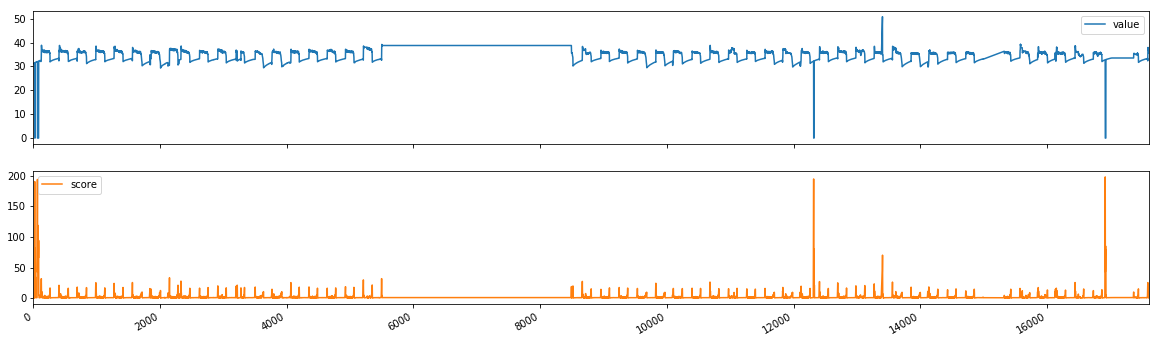

In [79]:
result.plot(figsize=[20,6], subplots=True)